In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline

from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device} will be used for training...")

cuda will be used for training...


In [3]:
train_data_path = os.path.join("dataset", "prototyping", "train")
valid_data_path = os.path.join("dataset", "prototyping", "valid")
print(f"Train path: {train_data_path}\nValid path: {valid_data_path}")

Train path: dataset\prototyping\train
Valid path: dataset\prototyping\valid


# 1. Defining Transforms for Data Augumentation

In [4]:
image_size = 256
batch_size = 16

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize([0, 0, 0], [1, 1, 1]),
])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(256),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [8]:
training_data = ImageFolder(train_data_path, transform=train_transforms)
valid_data = ImageFolder(valid_data_path, transform=test_transforms)

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [9]:
idx_to_class = {v: k for k, v in training_data.class_to_idx.items()}
idx_to_class

{0: 'fake', 1: 'real'}

In [7]:
def display_image(img_tensor, title=None):
  image = img_tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image
  # image = image.clip(0, 1)

  if title:
    plt.title(title)

  plt.imshow(image)
  plt.show()

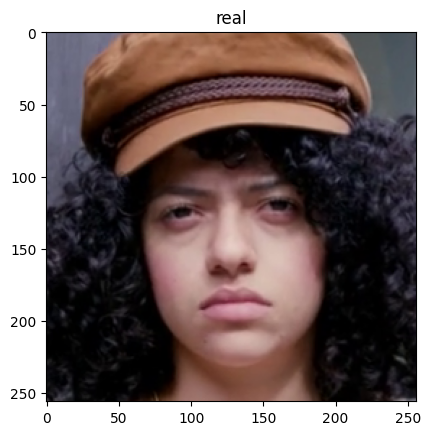

In [10]:
images, labels = next(iter(train_loader))
display_image(images[0], idx_to_class[labels[0].item()])

In [11]:
from torchvision.models import resnet152, ResNet152_Weights

model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
classifier = torch.nn.Sequential(
    nn.Linear(2048, 2),
    # nn.ReLU(),
    # nn.Dropout(p=0.2),
    # nn.Linear(1024, 512),
    # nn.ReLU(),
    # nn.Dropout(p=0.15),
    # nn.Linear(512, 128),
    # nn.ReLU(),
    # nn.Dropout(p=0.15),
    # nn.Linear(128, 2),
    nn.LogSoftmax(dim=1),
)
classifier

Sequential(
  (0): Linear(in_features=2048, out_features=2, bias=True)
  (1): LogSoftmax(dim=1)
)

In [14]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
checkpoint_path = "checkpoint.pt"

In [16]:
# Loading checkpoint
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["state_dict"])

C:\Users\navan\AppData\Local\Temp\ipykernel_27296\736372685.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


<All keys matched successfully>

# Hyper parameters

In [18]:
criterion = nn.NLLLoss()
epochs = 50
learning_rate = 0.005
validate_every = 5

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
validation_loss_min = np.Inf
model.to(device)

for e in range(epochs):
  running_loss = 0

  print(f"EPOCH {e + 1}:")
  i = 0
  for images, labels in tqdm.tqdm(train_loader):
    i += 1
    # print(f"{i} / {len(train_loader)} image being used for training")
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model.forward(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {e + 1} :: Running Loss: {running_loss / len(train_loader)}")

  validation_loss = 0

  if (e + 1) % validate_every == 0:
    with torch.no_grad():
      model.eval()

      for images, labels in tqdm.tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)

        validation_loss += loss.item()

    model.train()

    running_loss /= len(train_loader)
    validation_loss /= len(valid_loader)

    print(f"EPOCH {e + 1}:")
    print(f"Running Loss = {running_loss}\tValidation Loss: {validation_loss}")

    if validation_loss <= validation_loss_min:
      validation_loss_min = validation_loss
      torch.save({"state_dict": model.state_dict(), "valid_loss": validation_loss_min}, checkpoint_path)
      print(f"Minimum Validtion loss acquired, {validation_loss_min} to {validation_loss}")


EPOCH 1:


100%|██████████| 750/750 [03:48<00:00,  3.28it/s]


Epoch 1 :: Running Loss: 0.4652495240966479
EPOCH 2:


100%|██████████| 750/750 [02:40<00:00,  4.68it/s]


Epoch 2 :: Running Loss: 0.3050613360852003
EPOCH 3:


100%|██████████| 750/750 [02:36<00:00,  4.81it/s]


Epoch 3 :: Running Loss: 0.21611488278210164
EPOCH 4:


100%|██████████| 750/750 [02:34<00:00,  4.86it/s]


Epoch 4 :: Running Loss: 0.14573766026645898
EPOCH 5:


100%|██████████| 750/750 [02:33<00:00,  4.88it/s]


Epoch 5 :: Running Loss: 0.10039160722059508


100%|██████████| 13/13 [00:03<00:00,  3.65it/s]


EPOCH 5:
Running Loss = 0.10039160722059508	Validation Loss: 0.4970492388193424
Minimum Validtion loss acquired, inf to 0.4970492388193424
EPOCH 6:


100%|██████████| 750/750 [02:34<00:00,  4.85it/s]


Epoch 6 :: Running Loss: 0.09309593890110651
EPOCH 7:


100%|██████████| 750/750 [02:36<00:00,  4.78it/s]


Epoch 7 :: Running Loss: 0.06212723256453561
EPOCH 8:


100%|██████████| 750/750 [02:33<00:00,  4.87it/s]


Epoch 8 :: Running Loss: 0.04768392944017735
EPOCH 9:


100%|██████████| 750/750 [02:34<00:00,  4.86it/s]


Epoch 9 :: Running Loss: 0.06482681631518063
EPOCH 10:


100%|██████████| 750/750 [03:05<00:00,  4.03it/s] 


Epoch 10 :: Running Loss: 0.04353370511142809


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


EPOCH 10:
Running Loss = 0.04353370511142809	Validation Loss: 0.9373858846150912
EPOCH 11:


 13%|█▎        | 98/750 [00:20<02:16,  4.76it/s]


KeyboardInterrupt: 

# Metrics Calculation

In [20]:
validation_loss = 0
correct_valid = 0
total_valid = 0

with torch.no_grad():
    model.eval()

    for images, labels in tqdm.tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)
        validation_loss += loss.item()

        # Calculate validation accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        correct_valid += (top_class == labels.view(*top_class.shape)).sum().item()
        total_valid += labels.size(0)

validation_loss /= len(valid_loader)
validation_accuracy = correct_valid / total_valid * 100

print("Validation Accuracy:", validation_accuracy)

100%|██████████| 13/13 [00:02<00:00,  4.90it/s]

Validation Accuracy: 86.5


# Original Dataset Validation Accuracy

In [21]:
original_valid_set = ImageFolder("./dataset/DFWild-Cup/valid", transform=test_transforms)
original_valid_loader = DataLoader(original_valid_set, batch_size=batch_size)

In [22]:
original_valid_set.class_to_idx

{'fake': 0, 'real': 1}

In [23]:
from PIL import UnidentifiedImageError
corrupted_files = []

In [24]:
validation_loss = 0
correct_valid = 0
total_valid = 0

model.to(device)

with torch.no_grad():
    model.eval()

    try:
        for images, labels in tqdm.tqdm(original_valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            logps = model.forward(images)
            loss = criterion(logps, labels)
            validation_loss += loss.item()

            # Calculate validation accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            correct_valid += (top_class == labels.view(*top_class.shape)).sum().item()
            total_valid += labels.size(0)
    except UnidentifiedImageError as e:
        corrupted_files.append(e)

validation_loss /= len(valid_loader)
validation_accuracy = correct_valid / total_valid * 100
model.train()

print("Validation Accuracy:", validation_accuracy)

100%|██████████| 192/192 [01:16<00:00,  2.50it/s]

Validation Accuracy: 50.390625


# Testing the model with images

In [21]:
from PIL import Image

In [57]:
image_path = "image5.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = test_transforms(image).unsqueeze(0)

model.to(device)
model.eval()
input_tensor = input_tensor.to(device)

with torch.no_grad():
    output = model(input_tensor)

model.train()
output = torch.exp(output)
print("Output:", output)
predicted_class = torch.argmax(output, dim=1)
prediction = predicted_class.item()
print("Prediction:", idx_to_class[prediction])

Output: tensor([[1.4013e-45, 1.0000e+00]], device='cuda:0')
Prediction: real
